<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
#!pip install torchtext
#!pip install matplotlib
#!pip install sklearn

In [2]:
import torch
import torchtext
from torchtext import vocab
from tqdm import tqdm
import os
import pickle

In [3]:
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from torch.utils.data import random_split
from sklearn import model_selection

In [4]:
#torch.multiprocessing.set_start_method('spawn')

In [5]:
#from torchtext.data.functional import numericalize_tokens_from_iterator

In [6]:
DATA_PATH = 'data'
#%matplotlib inline

# # For Google Colab only:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
# #from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
# from google.colab import drive
# drive.mount('/content/gdrive')

# DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

In [7]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [8]:
len(captions)

118287

In [9]:
example = 2000

In [10]:
# captions = captions[:example]
# img_codes = img_codes[:example]

In [11]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [12]:
from torchtext import vocab

class VocabTorchText():
    '''
    Класс является инструментом по работе со словарем TorchText
    '''
    
    TAG_UNKNOWN = '<unk>'
    TAG_START = '<sos>'
    TAG_END = '<eos>'
    TAG_PAD = '<pad>'
    
    def __init__(self, captions, min_freq=5):
    
        self.vocab = vocab.build_vocab_from_iterator(self._vocab_itrerator(captions), min_freq=min_freq, specials=[self.TAG_PAD, self.TAG_START, self.TAG_END, self.TAG_UNKNOWN])
    
        self.dict_word_to_index = self.vocab.get_stoi()
        self.list_words = self.vocab.get_itos()
    
        self.pad_ix = self.dict_word_to_index[self.TAG_PAD]
        self.unk_ix = self.dict_word_to_index[self.TAG_UNKNOWN]
    
    def _vocab_itrerator(self, captions):
        '''
        Данный итератор разбирает последовательность списка спиков, чтобы достать все записи описаний
        '''
        for caption in captions:
            for sentence in caption:
                yield sentence.strip().split()
                
    def sequence_tokens_to_vector(self, sequence_tokens, max_len=None):
        '''
        Функция возвращает вектор предложения по входной последовательности токенов
        Делает это достаточно быстро
        '''
        max_len = max_len or len(sequence_tokens)
        sentence = np.ones(max_len, dtype='int64') * self.pad_ix
        row_ix = [self.dict_word_to_index[word] if word in self.dict_word_to_index.keys() else self.unk_ix for word in sequence_tokens[:max_len]]
        sentence[:len(row_ix)] = row_ix    

        return sentence                
    
    def vector_to_sequence_tokens(self, vector):
        '''
        Преобразует ветор обратно в список токенов
        '''
        sentence = []
        for index in vector:
            sentence.append(self.list_words[index])
        return sentence
    
    def remove_start_tags(self, sequence_tokens):
        result = []
        for token in sequence_tokens:
            if token == self.TAG_UNKNOWN or token == self.TAG_START or token == self.TAG_END or token == self.TAG_PAD:
                pass
            else:
                result.append(token)
        
        return result
    
    def __len__(self):
        return len(self.vocab)
                
vocab_class = VocabTorchText(captions)                

In [13]:
# #Вставляем стартовые и конечные токены, и делаем токенизацию
# for img_i in range(len(captions)):
#     for caption_i in range(len(captions[img_i])):
#         sentence = captions[img_i][caption_i]         
#         sentence = vocab_class.TAG_START+' '+sentence+' '+vocab_class.TAG_END
#         captions[img_i][caption_i] = sentence.split()

In [14]:
msg = captions[0][0].strip().split()
msg

['people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables', '.']

In [15]:
len(msg)

9

In [16]:
vector = vocab_class.sequence_tokens_to_vector(msg,20)
vector

array([  21, 1027,    9,   16,  134,  491,   81,  211,    5,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [17]:
vector = vocab_class.sequence_tokens_to_vector(msg)
vector

array([  21, 1027,    9,   16,  134,  491,   81,  211,    5])

In [18]:
vocab_class.vector_to_sequence_tokens(vector)

['people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables', '.']

In [19]:
#Поэкспериментируем со свойствами словаря

In [20]:
vocab_class.vocab.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'vocab': <torchtext._torchtext.Vocab at 0x7f56fa09e618>}

In [21]:
len(vocab_class.vocab)

10403

In [22]:
vocab_class.list_words[:10]

['<pad>', '<sos>', '<eos>', '<unk>', 'a', '.', 'on', 'of', 'the', 'in']

In [23]:
#train test split

In [24]:
#captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = model_selection.train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [25]:
#Временно сделаем чтобы train==val. Чтобы модель смогла переобучится
#train_img_codes, val_img_codes, train_captions, val_captions = img_codes, img_codes, captions, captions

In [26]:
del(img_codes)
del(captions)

In [27]:
class CaptionDataset(Dataset):
    '''
    Класс обслуживает torchtext vocab и список списков последовательностей для обработки
    и выдачу их по одному но равномерно
    '''
    
    def __init__(self, vocab, captions, img_codes, sentence_len=20, random_issue=True, split_tokens=True, add_eos=True):
        super().__init__()
        
        self.img_codes = img_codes
        self.vocab = vocab
        self.captions = captions
        self.sentence_len = sentence_len
        
        self.random_issue = random_issue
        self.split_tokens = split_tokens
        self.add_eos = add_eos
        
        self.captions_read_count = [] #Счетчик выдачи описаний, необходим для равномерной выдачи разных названий
        for captions_image in captions:
            self.captions_read_count.append(np.zeros(len(captions_image)))
                
    def __len__(self):
        return len(self.captions)
    
    def _get_sentence_(self, index):
        '''
        Функция выбирает необходимый подиндекс, делая равномерное распределение выдачи разных вариантов
        '''
        captions_image = self.captions[index]
        
        captions_read = self.captions_read_count[index]
        
        min_count = min(captions_read)

        bool_read = (captions_read == min_count) * 1
        
        if self.random_issue:
            sub_index = int(np.random.choice(np.arange(len(captions_read)),size=1, p=bool_read/np.sum(bool_read)))
        else:
            sub_index = int(np.argmax(bool_read))
        
        
        #print('index', index, sub_index)
        
        self.captions_read_count[index][sub_index] += 1

        caption = self.captions[index][sub_index]
        
        if self.add_eos:
            caption = self.vocab.TAG_START+' '+caption+' '+self.vocab.TAG_END
            
        if self.split_tokens:
            caption = caption.split()
        
        sequence_tokens = caption
        
        #print(sequence_tokens)
        
        return self.vocab.sequence_tokens_to_vector(sequence_tokens, self.sentence_len)
    
    def __getitem__(self, index):
        
        dict_result = {}
        dict_result['sentence'] = self._get_sentence_(index)
        
        dict_result['futures'] = self.img_codes[index]
        dict_result['labels'] = index
            
        return dict_result

In [28]:
ds = CaptionDataset(vocab_class, train_captions, train_img_codes, 20, random_issue=True)

In [29]:
#ds.captions

In [30]:
ds[0]

{'sentence': array([  1,  17, 294,   6,   8,  54, 589, 561, 146,   4, 398,   5,   2,
          0,   0,   0,   0,   0,   0,   0]),
 'futures': array([0.30702457, 0.33112672, 0.49947745, ..., 0.03013637, 0.29778057,
        0.2297566 ], dtype=float32),
 'labels': 0}

In [31]:
ds.captions_read_count[0]

array([0., 0., 0., 1., 0.])

In [32]:
#ds_m = CaptionDatasetMem(ds, 'data')

In [33]:
#Проверим работу датасета

In [34]:
ds.img_codes[1]

array([0.09798327, 0.11954759, 0.13371491, ..., 0.22059338, 0.43346354,
       0.26252404], dtype=float32)

In [35]:
len(ds)

106458

In [36]:
ds[1]

{'sentence': array([   1,   30,   18, 1956,  178,    9, 1067,   18,   10, 3083,  719,
         239,    4,  315,    7,   54,    5,    2,    0,    0]),
 'futures': array([0.09798327, 0.11954759, 0.13371491, ..., 0.22059338, 0.43346354,
        0.26252404], dtype=float32),
 'labels': 1}

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [37]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [38]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size=2048, n_tokens=20, emb_size=128, lstm_units=256):
        super(self.__class__, self).__init__()


        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        #<YOUR CODE>
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
        
        self.logits = nn.Linear(lstm_units, n_tokens)        
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM
        #logits = <YOUR_CODE> 
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        captions_emb = self.emb(captions_ix)
        #lstm_out, (hn, cn) = self.lstm(captions_emb, (initial_cell, initial_hid))   
        #lstm_out = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        lstm_out = self.lstm(captions_emb, (initial_cell.unsqueeze(0), initial_hid.unsqueeze(0)))
        #logits = self.logits(lstm_out)        
        logits = self.logits(lstm_out[0])
        
        return logits        

In [39]:
len(vocab_class)

10403

In [40]:
decoder = CaptionNet(cnn_feature_size=2048, n_tokens=len(vocab_class), emb_size=128, lstm_units=256)

In [41]:
def compute_loss(network, vocab, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    #loss = <YOUR CODE>
    
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    #image_vectors = image_vectors.cuda()
    #captions_ix_next = captions_ix_next.cuda()
    
    #print('image_vectors.shape', image_vectors.shape)
    #print('captions_ix_inp.shape', captions_ix_inp.shape)
    
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    #logits_for_next = logits_for_next.transpose(1, 2)  
    
    next_reshaped = captions_ix_next.to(device).view(-1)
    logits_reshaped = logits_for_next.view(-1, logits_for_next.size()[-1])

    
    #loss = F.cross_entropy(logits_for_next, captions_ix_next, ignore_index = pad_ix).reshape(1)    
    
    mask = captions_ix_next != vocab.pad_ix
    
    #cross_entropy = nn.CrossEntropyLoss(reduction = 'none').to(device)
    cross_entropy = nn.CrossEntropyLoss(reduction = 'none').to(device)
    loss = cross_entropy(logits_reshaped, next_reshaped)
    #print('loss 1 ', loss.shape)
    
    loss = loss.view(captions_ix_next.size()[0], captions_ix_next.size()[1]) * mask.float()
    #print('loss 2 ', loss.shape)
    loss = loss.mean(dim = -1)
    #print('loss 3 ', loss.shape)
    loss = loss.mean(dim = -1)
    #print('loss 4 ', loss.shape)
    #loss = loss.view(-1)
    #print('loss 5 ', loss.shape)
    
    
    return loss

In [42]:
def compute_loss(network, vocab, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    

    # apply the network, get predictions for captions_ix_next
    image_vectors = image_vectors.cuda()
    captions_ix_next = captions_ix_next.cuda()
    logits_for_next = network.forward(image_vectors, captions_ix_inp.cuda())
    logits_for_next = logits_for_next.transpose(1, 2)  

    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(logits_for_next, captions_ix_next, ignore_index = vocab.pad_ix).reshape(1)

    return loss

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [43]:
#<your code here>

In [44]:
batch_size = 128  # adjust me
n_epochs = 18  # adjust me
#n_epochs = 10  # adjust me
n_epochs = 50  # adjust me

In [45]:
device = 'cuda'

In [46]:
#bi = BatchIterator(ds, ds.labels, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [47]:
ds_train = CaptionDataset(vocab_class, train_captions, train_img_codes, 20, random_issue=True)
len(ds_train)

106458

In [48]:
ds_valid = CaptionDataset(vocab_class, val_captions, val_img_codes, 20, random_issue=False)
len(ds_valid)

11829

In [49]:
decoder = decoder.to(device)

In [50]:
ds[0]

{'sentence': array([   1,   96,   21,    6,   39,   68,  294, 1820,  221,    4, 2690,
         331,    2,    0,    0,    0,    0,    0,    0,    0]),
 'futures': array([0.30702457, 0.33112672, 0.49947745, ..., 0.03013637, 0.29778057,
        0.2297566 ], dtype=float32),
 'labels': 0}

In [51]:
def collate_fn_dataloader(batch):
    list_sentence = []
    list_futures = []
    list_labels = []
    for ds_item in batch:
        list_sentence.append(ds_item['sentence'])
        list_futures.append(ds_item['futures'])
        list_labels.append(ds_item['labels'])

    dict_result = {}
        
    list_sentence = np.array(list_sentence)
    list_futures = np.array(list_futures)
        
    dict_result['sentence'] = torch.tensor(list_sentence)
    dict_result['futures'] = torch.tensor(list_futures)
    dict_result['labels'] = torch.tensor(list_labels)
        
    return dict_result

In [52]:
def generate_caption_vectors_neck(decoder, vectors_neck, vocab_class, 
                     t=1, sample=True, max_len=100):
    
    vocab = vocab_class.list_words
    
    with torch.no_grad():
        
        batch_size = vectors_neck.shape[0]
        #print('batch_size', batch_size)
        
        if batch_size > 1:
            caption_prefix = [vocab_class.TAG_START]
        else:
            caption_prefix = [vocab_class.TAG_START]

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся

            #<YOUR CODE>
            #print('caption_prefix',caption_prefix)
            
            prefix_ix = vocab_class.sequence_tokens_to_vector(caption_prefix)
            
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).unsqueeze(0).cuda()
            
            next_word_logits = decoder.forward(vectors_neck.cuda(), prefix_ix)
            
            
            next_word_logits = next_word_logits[0, -1]
            
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                #print('next_word_probs', next_word_probs.shape)
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == vocab_class.TAG_END:
                break            
            pass
            
    return caption_prefix

In [53]:
from warmup_scheduler import GradualWarmupScheduler

In [54]:
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

In [55]:
lr = 0.001

In [56]:
#optimizer = <YOUR CODE> # favourite one
optimizer = torch.optim.Adam(decoder.parameters(),lr=lr)

In [57]:
from torch.optim.lr_scheduler import StepLR

In [58]:
# num_steps = len(ds_train_mem) * n_epochs
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)

In [59]:
# scheduler_steplr = StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_steplr)

In [60]:
#scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=3000, cycle_mult=1.0, max_lr=0.01, min_lr=0.0001, warmup_steps=500, gamma=1)

In [61]:
from nltk.translate.bleu_score import corpus_bleu

In [62]:
from bleu.bleu import Bleu
from meteor.meteor import Meteor
from rouge.rouge import Rouge
#from cider.cider import Cider
from cider2.cider import Cider
from spice.spice import Spice
from ciderD.ciderD import CiderD

In [63]:
metrics_bleu4 = []

dict_params = {}

dict_params['train_loss'] = []
dict_params['val_loss'] = []
#dict_params['val_Rouge'] = []

scorers = [
    (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
    (Rouge(), "ROUGE_L"),
    (Cider(), "CIDEr"),
    (CiderD(), "CIDErD")
#     (Spice(), "SPICE")
#     (Meteor(), "METEOR")
]

for _, method in scorers:
    if isinstance(method, list):
        for sub_method in method:
            dict_params['val_' + sub_method] = []
    else:    
        dict_params['val_' + method] = []

for epoch in range(n_epochs):

    for _, method in scorers:
        if isinstance(method, list):
            for sub_method in method:
                dict_params['epoch_' + sub_method] = 0
        else:    
            dict_params['epoch_' + method] = 0  
    
    train_loss=0
    
    bi = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn_dataloader)
    #bi = BatchIterator(ds_train_mem, ds_train.labels, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, device=device)
    
    n_batches_per_epoch = 0
    
    decoder.train(True)
    
    for batch in tqdm(bi):
        
        #print('1')
        
        optimizer.zero_grad()
        
        loss_t = compute_loss(decoder, vocab_class, batch['futures'].to(device), batch['sentence'].to(device))
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        
        optimizer.step()
        #lr_scheduler.step()
        #scheduler_warmup.step(epoch)
        #scheduler.step()
        
        train_loss += loss_t.item()
        
        n_batches_per_epoch += 1
        
    train_loss /= n_batches_per_epoch

    print('lr', epoch, optimizer.param_groups[0]['lr'])
    
    dict_params['train_loss'].append(train_loss)
    
    bi = DataLoader(ds_valid, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_dataloader)
    #bi = BatchIterator(ds_valid_mem, ds_valid.labels, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, device=device)
    
    val_loss=0
    n_validation_batches = 0
    
    n_validation_scores = 0
    
    hypotheses = []
    references = []
    
    res = {}
    gts = {}
        
    decoder.train(False)
    decoder.eval()
    for batch in tqdm(bi):
        
        loss_t = compute_loss(decoder, vocab_class, batch['futures'].to(device), batch['sentence'].to(device))
        val_loss += loss_t.item()
        n_validation_batches += 1
        
        # =================================================
        # Compute scores
        # =================================================
        
        batch_size = batch['futures'].shape[0]
        

        
        
        for i in range(batch_size):
            sent = batch['futures'][i]
            src_cap = generate_caption_vectors_neck(decoder, sent.unsqueeze(0), vocab_class, sample=False)
            src_cap = vocab_class.remove_start_tags(src_cap)
            
            hypotheses.append(src_cap)
            
            src_cap = ' '.join(src_cap)
            
            res[n_validation_scores] = [src_cap]
            
#             dst_cap = batch['sentence'][i]
#             dst_cap = vocab_class.vector_to_sequence_tokens(dst_cap) 
#             dst_cap = vocab_class.remove_start_tags(dst_cap)
#             dst_cap = ' '.join(dst_cap)
#             gts = {'tokenized sentences': [dst_cap]}
            
            label = batch['labels'][i]
            list_dst_cap = ds_valid.captions[label]
            gts[n_validation_scores] = list_dst_cap
            
            references.append(list(map(lambda c: c.split(), list_dst_cap)))
            
        n_validation_scores += 1

#         for scorer, method in scorers:
#             #print 'computing %s score...'%(scorer.method())
#             score, scores = scorer.compute_score(gts, res)

#             #print('epoch_' + method, score)

#             if isinstance(method, list):
#                 for i, sub_method in enumerate(method):
#                     dict_params['epoch_' + sub_method] += score[i]
#             else:
#                 dict_params['epoch_' + method] += score

    val_loss /= n_validation_batches
    
    
    dict_params['val_loss'].append(val_loss)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    #hypotheses.extend(preds)

    
#     for _, method in scorers:
#         if isinstance(method, list):
#             for sub_method in method:
#                 dict_params['epoch_'+sub_method] /= n_validation_scores
#                 dict_params['val_'+sub_method].append(dict_params['epoch_'+sub_method])

#                 print('val '+sub_method, dict_params['epoch_'+sub_method])
#         else:
#             dict_params['epoch_'+method] /= n_validation_scores
#             dict_params['val_'+method].append(dict_params['epoch_'+method])

#             print('val '+method, dict_params['epoch_'+method])

    assert len(references) == len(hypotheses)
 
    for scorer, method in scorers:
        #print 'computing %s score...'%(scorer.method())
        score, scores = scorer.compute_score(gts, res)

        #print('epoch_' + method, score)

        if isinstance(method, list):
            for i, sub_method in enumerate(method):
                dict_params['epoch_' + sub_method] = score[i]
                dict_params['val_'+sub_method].append(dict_params['epoch_'+sub_method])
                print('val '+sub_method, dict_params['epoch_'+sub_method])
        else:
            dict_params['epoch_' + method] = score
            dict_params['val_'+method].append(dict_params['epoch_'+method])
            print('val '+method, dict_params['epoch_'+method])

    #print('references',references[0])
    #print('hypotheses',hypotheses[0])
    bleu4 = corpus_bleu(references, hypotheses)
    
    metrics_bleu4.append(bleu4)

    print(f'bleu4 = {bleu4:.3f}')            
            
print("Finished!")

100%|█████████████████████████████████████████| 832/832 [00:40<00:00, 20.62it/s]


lr 0 0.001


100%|███████████████████████████████████████████| 93/93 [02:26<00:00,  1.57s/it]



Epoch: 0, train loss: 3.801771485175078, val loss: 2.9911890593908166
val Bleu_1 0.6364562118119792
val Bleu_2 0.41191495267002504
val Bleu_3 0.27160846439363184
val Bleu_4 0.18141138667863654
val ROUGE_L 0.49345173489059624
val CIDEr 0.6531684892893221
val CIDErD 0.5400993008776452
bleu4 = 0.153


100%|███████████████████████████████████████| 2009/2009 [01:22<00:00, 24.36it/s]


lr 1 0.001


100%|█████████████████████████████████████████| 224/224 [02:26<00:00,  1.53it/s]



Epoch: 1, train loss: 2.9192727114087376, val loss: 2.6304339841008186
val Bleu_1 0.6819153484392125
val Bleu_2 0.4706395449449246
val Bleu_3 0.3200966368235378
val Bleu_4 0.21617610027894496
val ROUGE_L 0.5132758374354445
val CIDEr 0.835430977897938
val CIDErD 0.6901092242667964
bleu4 = 0.187


100%|█████████████████████████████████████| 10646/10646 [02:40<00:00, 66.19it/s]


lr 2 0.001


100%|███████████████████████████████████████| 1183/1183 [02:31<00:00,  7.83it/s]



Epoch: 2, train loss: 2.7405399135488016, val loss: 2.527329108620335
val Bleu_1 0.6443776212708202
val Bleu_2 0.42607996945847443
val Bleu_3 0.28134984740467445
val Bleu_4 0.18373046390112194
val ROUGE_L 0.4860051473164853
val CIDEr 0.6617368690151755
val CIDErD 0.5702456613837231
bleu4 = 0.183


100%|█████████████████████████████████████| 11829/11829 [03:15<00:00, 60.49it/s]


lr 3 0.001


100%|███████████████████████████████████████| 1315/1315 [02:42<00:00,  8.10it/s]



Epoch: 3, train loss: 2.6262493536351186, val loss: 2.475240899945393
val Bleu_1 0.6612718418790704
val Bleu_2 0.4386173716132394
val Bleu_3 0.29234707476032384
val Bleu_4 0.19733034043531572
val ROUGE_L 0.493428710372237
val CIDEr 0.7233335767328434
val CIDErD 0.6142833169447558
bleu4 = 0.192


100%|█████████████████████████████████████| 35486/35486 [07:44<00:00, 76.33it/s]


lr 4 0.001


100%|███████████████████████████████████████| 3943/3943 [03:09<00:00, 20.77it/s]



Epoch: 4, train loss: 2.726886797257329, val loss: 2.615472136764033
val Bleu_1 0.641252267758277
val Bleu_2 0.4199528354512896
val Bleu_3 0.2723388962928561
val Bleu_4 0.1787457035149308
val ROUGE_L 0.4807915242373375
val CIDEr 0.6457356778824396
val CIDErD 0.5544775388542967
bleu4 = 0.182


100%|█████████████████████████████████████| 35486/35486 [07:33<00:00, 78.33it/s]


lr 5 0.001


100%|███████████████████████████████████████| 3943/3943 [02:46<00:00, 23.70it/s]



Epoch: 5, train loss: 2.75032018695388, val loss: 2.583624499312156
val Bleu_1 0.6519187467062557
val Bleu_2 0.4321432946440733
val Bleu_3 0.2833549815100222
val Bleu_4 0.18702843497664456
val ROUGE_L 0.48140749279283856
val CIDEr 0.6844633382932295
val CIDErD 0.5770719399410862
bleu4 = 0.188


100%|█████████████████████████████████████| 35486/35486 [07:44<00:00, 76.38it/s]


lr 6 0.001


100%|███████████████████████████████████████| 3943/3943 [02:47<00:00, 23.48it/s]



Epoch: 6, train loss: 2.75892681415358, val loss: 2.6158893138601065
val Bleu_1 0.6333930592229199
val Bleu_2 0.41870971467997053
val Bleu_3 0.27569019571122333
val Bleu_4 0.184542334414295
val ROUGE_L 0.4780713718324085
val CIDEr 0.6592020696558972
val CIDErD 0.5667349996712943
bleu4 = 0.187


100%|█████████████████████████████████████| 35486/35486 [08:03<00:00, 73.33it/s]


lr 7 0.001


100%|███████████████████████████████████████| 3943/3943 [02:39<00:00, 24.72it/s]



Epoch: 7, train loss: 2.775037658622392, val loss: 2.6264974908752547
val Bleu_1 0.655167528511708
val Bleu_2 0.4349221513626801
val Bleu_3 0.28915468172306114
val Bleu_4 0.19538844655983637
val ROUGE_L 0.48587925783562375
val CIDEr 0.6884926674285506
val CIDErD 0.5907980588006408
bleu4 = 0.197


100%|█████████████████████████████████████| 35486/35486 [08:03<00:00, 73.37it/s]


lr 8 0.001


100%|███████████████████████████████████████| 3943/3943 [02:37<00:00, 25.04it/s]



Epoch: 8, train loss: 2.822430603909518, val loss: 2.6483620167715793
val Bleu_1 0.6558956780209351
val Bleu_2 0.44105024186444797
val Bleu_3 0.29495972992581376
val Bleu_4 0.20046798747552524
val ROUGE_L 0.4908612803304902
val CIDEr 0.7120844730605879
val CIDErD 0.6052220393068076
bleu4 = 0.201


100%|█████████████████████████████████████| 35486/35486 [08:07<00:00, 72.83it/s]


lr 9 0.001


100%|███████████████████████████████████████| 3943/3943 [02:39<00:00, 24.72it/s]



Epoch: 9, train loss: 2.8363664417657737, val loss: 2.6930393525830327
val Bleu_1 0.6392438132332533
val Bleu_2 0.4179987526363718
val Bleu_3 0.2737082514094753
val Bleu_4 0.1824735315090432
val ROUGE_L 0.4768919928523413
val CIDEr 0.6438394994084697
val CIDErD 0.557303765435906
bleu4 = 0.185


100%|█████████████████████████████████████| 35486/35486 [07:27<00:00, 79.24it/s]


lr 10 0.001


100%|███████████████████████████████████████| 3943/3943 [03:02<00:00, 21.60it/s]



Epoch: 10, train loss: 2.864410425340391, val loss: 2.713398548482246
val Bleu_1 0.6648967122490383
val Bleu_2 0.4440518485551134
val Bleu_3 0.2977125770606124
val Bleu_4 0.20186325788011772
val ROUGE_L 0.49078368818859613
val CIDEr 0.6985382541175725
val CIDErD 0.6098394318131288
bleu4 = 0.205


100%|█████████████████████████████████████| 35486/35486 [07:27<00:00, 79.28it/s]


lr 11 0.001


100%|███████████████████████████████████████| 3943/3943 [03:07<00:00, 21.03it/s]



Epoch: 11, train loss: 2.9135849413410595, val loss: 2.7322751946204997
val Bleu_1 0.6621407241507872
val Bleu_2 0.44578265517908744
val Bleu_3 0.2979151434667661
val Bleu_4 0.2022258046679891
val ROUGE_L 0.49655937363402114
val CIDEr 0.7176196466795159
val CIDErD 0.6204743972928656
bleu4 = 0.203


100%|█████████████████████████████████████| 35486/35486 [07:35<00:00, 77.82it/s]


lr 12 0.001


100%|███████████████████████████████████████| 3943/3943 [02:59<00:00, 22.02it/s]



Epoch: 12, train loss: 2.9716400177097975, val loss: 2.779527488121852
val Bleu_1 0.6588335825678118
val Bleu_2 0.4418379947039321
val Bleu_3 0.2951723773731773
val Bleu_4 0.19975807134932652
val ROUGE_L 0.49172926826674196
val CIDEr 0.6939885235351725
val CIDErD 0.601908501305183
bleu4 = 0.202


100%|█████████████████████████████████████| 35486/35486 [07:48<00:00, 75.78it/s]


lr 13 0.001


100%|███████████████████████████████████████| 3943/3943 [02:33<00:00, 25.77it/s]



Epoch: 13, train loss: 2.9915188359047202, val loss: 2.7937038976197432
val Bleu_1 0.6738776114979831
val Bleu_2 0.4553848059002475
val Bleu_3 0.30639840431330834
val Bleu_4 0.20871312951918422
val ROUGE_L 0.4973826420130691
val CIDEr 0.7237678282888399
val CIDErD 0.6271378142375963
bleu4 = 0.212


100%|█████████████████████████████████████| 35486/35486 [08:10<00:00, 72.38it/s]


lr 14 0.001


100%|███████████████████████████████████████| 3943/3943 [02:35<00:00, 25.28it/s]



Epoch: 14, train loss: 2.996633513178839, val loss: 2.7919882783090406
val Bleu_1 0.662409556645446
val Bleu_2 0.44918378992444735
val Bleu_3 0.3024672163349667
val Bleu_4 0.20410059040182663
val ROUGE_L 0.4932795753237874
val CIDEr 0.7122924809308818
val CIDErD 0.6117404533217505
bleu4 = 0.203


100%|█████████████████████████████████████| 35486/35486 [07:59<00:00, 74.02it/s]


lr 15 0.001


100%|███████████████████████████████████████| 3943/3943 [02:38<00:00, 24.88it/s]



Epoch: 15, train loss: 2.9932986744370083, val loss: 2.806232465090499
val Bleu_1 0.664548039473354
val Bleu_2 0.4462392883752498
val Bleu_3 0.2977174799601451
val Bleu_4 0.19974363916436275
val ROUGE_L 0.49201254288281776
val CIDEr 0.7114547097573779
val CIDErD 0.6103440803789616
bleu4 = 0.201


100%|█████████████████████████████████████| 35486/35486 [08:16<00:00, 71.45it/s]


lr 16 0.001


100%|███████████████████████████████████████| 3943/3943 [02:40<00:00, 24.62it/s]



Epoch: 16, train loss: 3.1572829335281294, val loss: 2.9160975331647006
val Bleu_1 0.6462076332912342
val Bleu_2 0.42795858545714566
val Bleu_3 0.2830406644021067
val Bleu_4 0.189310356719419
val ROUGE_L 0.48347410448437356
val CIDEr 0.658743003432535
val CIDErD 0.5701497458542522
bleu4 = 0.188


100%|█████████████████████████████████████| 35486/35486 [07:41<00:00, 76.82it/s]


lr 17 0.001


100%|███████████████████████████████████████| 3943/3943 [03:04<00:00, 21.42it/s]



Epoch: 17, train loss: 3.0985497704106133, val loss: 2.896215523979309
val Bleu_1 0.6553179246187625
val Bleu_2 0.43412638906317647
val Bleu_3 0.2844194702410162
val Bleu_4 0.1875855966246905
val ROUGE_L 0.4839396839332741
val CIDEr 0.6749933189541603
val CIDErD 0.588443307837295
bleu4 = 0.189


100%|█████████████████████████████████████| 35486/35486 [07:41<00:00, 76.85it/s]


lr 18 0.001


100%|███████████████████████████████████████| 3943/3943 [02:06<00:00, 31.18it/s]



Epoch: 18, train loss: 3.139485820969163, val loss: 2.9208732916865587
val Bleu_1 0.652420073722489
val Bleu_2 0.4417964841855899
val Bleu_3 0.294996960208258
val Bleu_4 0.1975578708553144
val ROUGE_L 0.4847411231219882
val CIDEr 0.7018792461920949
val CIDErD 0.6000399386004257
bleu4 = 0.201


100%|████████████████████████████████████| 35486/35486 [05:52<00:00, 100.78it/s]


lr 19 0.001


100%|███████████████████████████████████████| 3943/3943 [01:36<00:00, 41.02it/s]



Epoch: 19, train loss: 3.1472836418548393, val loss: 2.9180134454264484
val Bleu_1 0.6634786108283265
val Bleu_2 0.44955869512733226
val Bleu_3 0.30249218544755146
val Bleu_4 0.20440265141616593
val ROUGE_L 0.49520060604608374
val CIDEr 0.7228814055564634
val CIDErD 0.6307014212614128
bleu4 = 0.205


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.31it/s]


lr 20 0.001


100%|███████████████████████████████████████| 3943/3943 [01:33<00:00, 42.26it/s]



Epoch: 20, train loss: 3.171618236085107, val loss: 2.948021518150139
val Bleu_1 0.6592192250156672
val Bleu_2 0.44872418142644604
val Bleu_3 0.30390119262952553
val Bleu_4 0.2075473577646633
val ROUGE_L 0.4923284893945447
val CIDEr 0.7213072158804416
val CIDErD 0.6201558237129706
bleu4 = 0.209


100%|████████████████████████████████████| 35486/35486 [05:51<00:00, 101.02it/s]


lr 21 0.001


100%|███████████████████████████████████████| 3943/3943 [01:31<00:00, 43.00it/s]



Epoch: 21, train loss: 3.1729474488897953, val loss: 2.9599475621300364
val Bleu_1 0.6712281309544266
val Bleu_2 0.4499002289097685
val Bleu_3 0.300446707893549
val Bleu_4 0.20317909267896722
val ROUGE_L 0.49380556487295435
val CIDEr 0.7064853042221084
val CIDErD 0.6172340471331643
bleu4 = 0.204


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.15it/s]


lr 22 0.001


100%|███████████████████████████████████████| 3943/3943 [01:36<00:00, 41.03it/s]



Epoch: 22, train loss: 3.181248151591872, val loss: 2.977865806818311
val Bleu_1 0.6488178674890046
val Bleu_2 0.4365201776095543
val Bleu_3 0.29224818008750836
val Bleu_4 0.19681398368344932
val ROUGE_L 0.4885415771834833
val CIDEr 0.7003742301768382
val CIDErD 0.6049682548437275
bleu4 = 0.198


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.16it/s]


lr 23 0.001


100%|███████████████████████████████████████| 3943/3943 [01:32<00:00, 42.41it/s]



Epoch: 23, train loss: 3.2005801281557877, val loss: 2.978042450995425
val Bleu_1 0.6657508934866484
val Bleu_2 0.4503103387276094
val Bleu_3 0.3038680998964824
val Bleu_4 0.20757926454604816
val ROUGE_L 0.4938474095416973
val CIDEr 0.7174978528380264
val CIDErD 0.6244295409599031
bleu4 = 0.206


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.39it/s]


lr 24 0.001


100%|███████████████████████████████████████| 3943/3943 [01:35<00:00, 41.49it/s]



Epoch: 24, train loss: 3.2939406216483853, val loss: 3.030812242370918
val Bleu_1 0.6569451073985524
val Bleu_2 0.44133874607419205
val Bleu_3 0.29289885572670055
val Bleu_4 0.19610768148273808
val ROUGE_L 0.48657109466842424
val CIDEr 0.689974864516547
val CIDErD 0.5999538432492757
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:49<00:00, 101.41it/s]


lr 25 0.001


100%|███████████████████████████████████████| 3943/3943 [01:37<00:00, 40.60it/s]



Epoch: 25, train loss: 3.300551107099022, val loss: 3.093956595609371
val Bleu_1 0.649836567216064
val Bleu_2 0.43017367823401526
val Bleu_3 0.28489667392869156
val Bleu_4 0.19001499755427445
val ROUGE_L 0.4867714193869126
val CIDEr 0.6865653425074502
val CIDErD 0.5940108987669063
bleu4 = 0.191


100%|████████████████████████████████████| 35486/35486 [05:49<00:00, 101.45it/s]


lr 26 0.001


100%|███████████████████████████████████████| 3943/3943 [01:39<00:00, 39.66it/s]



Epoch: 26, train loss: 3.310146716187182, val loss: 3.0672060236421723
val Bleu_1 0.6374794670560177
val Bleu_2 0.42042916464898006
val Bleu_3 0.2759133238212141
val Bleu_4 0.1828374434739793
val ROUGE_L 0.4771628857132442
val CIDEr 0.6694458830142771
val CIDErD 0.5836958817528523
bleu4 = 0.183


100%|████████████████████████████████████| 35486/35486 [05:49<00:00, 101.60it/s]


lr 27 0.001


100%|███████████████████████████████████████| 3943/3943 [01:35<00:00, 41.24it/s]



Epoch: 27, train loss: 3.330187137249337, val loss: 3.1853045520218926
val Bleu_1 0.6529964000846886
val Bleu_2 0.43927476146258393
val Bleu_3 0.29406971499230006
val Bleu_4 0.19890496302446264
val ROUGE_L 0.4875900849801539
val CIDEr 0.6843746263757375
val CIDErD 0.5962318772337212
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:49<00:00, 101.53it/s]


lr 28 0.001


100%|███████████████████████████████████████| 3943/3943 [01:32<00:00, 42.85it/s]



Epoch: 28, train loss: 3.363435868081666, val loss: 3.0973976638424134
val Bleu_1 0.663495896892465
val Bleu_2 0.44264815254882844
val Bleu_3 0.296039758392912
val Bleu_4 0.20081297271407275
val ROUGE_L 0.48981103341922105
val CIDEr 0.697605954202808
val CIDErD 0.606118924175949
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.13it/s]


lr 29 0.001


100%|███████████████████████████████████████| 3943/3943 [01:36<00:00, 40.82it/s]



Epoch: 29, train loss: 3.330390587575889, val loss: 3.09069437908697
val Bleu_1 0.655238819809309
val Bleu_2 0.4374232351022341
val Bleu_3 0.2897754785579717
val Bleu_4 0.1938370989451924
val ROUGE_L 0.488355944885045
val CIDEr 0.6946499910778102
val CIDErD 0.6112192468095475
bleu4 = 0.194


100%|████████████████████████████████████| 35486/35486 [05:49<00:00, 101.56it/s]


lr 30 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.67it/s]



Epoch: 30, train loss: 3.3954809412342555, val loss: 3.11989354219589
val Bleu_1 0.6587038054513591
val Bleu_2 0.4429217826522125
val Bleu_3 0.29944416533360985
val Bleu_4 0.20650404583371615
val ROUGE_L 0.49331307428539406
val CIDEr 0.698811752374026
val CIDErD 0.6158861403990877
bleu4 = 0.205


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.37it/s]


lr 31 0.001


100%|███████████████████████████████████████| 3943/3943 [01:32<00:00, 42.64it/s]



Epoch: 31, train loss: 3.336195961896458, val loss: 3.120133824663479
val Bleu_1 0.6647371906502008
val Bleu_2 0.44613326704622763
val Bleu_3 0.29905549786069147
val Bleu_4 0.20435001947635392
val ROUGE_L 0.4858455011517454
val CIDEr 0.7205007649191821
val CIDErD 0.6166838223178571
bleu4 = 0.205


100%|████████████████████████████████████| 35486/35486 [05:49<00:00, 101.54it/s]


lr 32 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.93it/s]



Epoch: 32, train loss: 3.3713557545431825, val loss: 3.118704524585628
val Bleu_1 0.6506424137433077
val Bleu_2 0.43689131127226577
val Bleu_3 0.29306842425389
val Bleu_4 0.1974666108209882
val ROUGE_L 0.48834733053792295
val CIDEr 0.7021744163464587
val CIDErD 0.6035983345789578
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:51<00:00, 100.93it/s]


lr 33 0.001


100%|███████████████████████████████████████| 3943/3943 [01:36<00:00, 40.72it/s]



Epoch: 33, train loss: 3.3207707398774784, val loss: 3.100661648897964
val Bleu_1 0.6542270671459898
val Bleu_2 0.43261511615118137
val Bleu_3 0.2837861243671767
val Bleu_4 0.18889923722630772
val ROUGE_L 0.4858591678824872
val CIDEr 0.6735407624470201
val CIDErD 0.5915092732023765
bleu4 = 0.192


100%|████████████████████████████████████| 35486/35486 [05:51<00:00, 101.03it/s]


lr 34 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.64it/s]



Epoch: 34, train loss: 3.3284398708313003, val loss: 3.07096500958158
val Bleu_1 0.6520421795972743
val Bleu_2 0.43409308584237943
val Bleu_3 0.28764493625219645
val Bleu_4 0.1928338114395019
val ROUGE_L 0.4862969483547249
val CIDEr 0.693637479052197
val CIDErD 0.6015211564868322
bleu4 = 0.194


100%|████████████████████████████████████| 35486/35486 [05:49<00:00, 101.55it/s]


lr 35 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.53it/s]



Epoch: 35, train loss: 3.3063090468839738, val loss: 3.0768395223020146
val Bleu_1 0.658607673562983
val Bleu_2 0.4434165442975753
val Bleu_3 0.29413929382227155
val Bleu_4 0.19696392558756032
val ROUGE_L 0.4909783871447354
val CIDEr 0.694530634333353
val CIDErD 0.6018935654831372
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.32it/s]


lr 36 0.001


100%|███████████████████████████████████████| 3943/3943 [01:33<00:00, 42.06it/s]



Epoch: 36, train loss: 3.2767040312982214, val loss: 3.0628858404718255
val Bleu_1 0.6591882130641571
val Bleu_2 0.4398409479199443
val Bleu_3 0.2937799647002679
val Bleu_4 0.19820948850693015
val ROUGE_L 0.4906311831988235
val CIDEr 0.6840147182134881
val CIDErD 0.6028054675220282
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.30it/s]


lr 37 0.001


100%|███████████████████████████████████████| 3943/3943 [01:32<00:00, 42.42it/s]



Epoch: 37, train loss: 3.2600707460140446, val loss: 3.0550859468768703
val Bleu_1 0.6700960719931736
val Bleu_2 0.44839052093394555
val Bleu_3 0.2980058463738728
val Bleu_4 0.19947436864454932
val ROUGE_L 0.4918176113522395
val CIDEr 0.6754419030549815
val CIDErD 0.6019543928550063
bleu4 = 0.199


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.29it/s]


lr 38 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.55it/s]



Epoch: 38, train loss: 3.29078258810422, val loss: 3.0512456409737085
val Bleu_1 0.6680127523910576
val Bleu_2 0.44382870312160055
val Bleu_3 0.291813858846596
val Bleu_4 0.19331411462401707
val ROUGE_L 0.49346628164202955
val CIDEr 0.6924552066507115
val CIDErD 0.6126470893089904
bleu4 = 0.199


100%|████████████████████████████████████| 35486/35486 [05:53<00:00, 100.52it/s]


lr 39 0.001


100%|███████████████████████████████████████| 3943/3943 [01:35<00:00, 41.38it/s]



Epoch: 39, train loss: 3.261459903040001, val loss: 3.046343469465562
val Bleu_1 0.6648908213483524
val Bleu_2 0.4447584299961015
val Bleu_3 0.297060050638577
val Bleu_4 0.20024900970689688
val ROUGE_L 0.49393869317049593
val CIDEr 0.6934682811439467
val CIDErD 0.6177067947702274
bleu4 = 0.202


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.30it/s]


lr 40 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.75it/s]



Epoch: 40, train loss: 3.258936705388675, val loss: 3.0444908058646365
val Bleu_1 0.6615169217399541
val Bleu_2 0.4414855632290908
val Bleu_3 0.29246980588011257
val Bleu_4 0.1946691798752515
val ROUGE_L 0.48990279792005087
val CIDEr 0.6810327494238644
val CIDErD 0.5970851013465934
bleu4 = 0.195


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.25it/s]


lr 41 0.001


100%|███████████████████████████████████████| 3943/3943 [01:39<00:00, 39.61it/s]



Epoch: 41, train loss: 3.260014072906297, val loss: 3.041824832381012
val Bleu_1 0.6499869997872539
val Bleu_2 0.4301910402475496
val Bleu_3 0.2832100434351632
val Bleu_4 0.19014822208019774
val ROUGE_L 0.4869962216151264
val CIDEr 0.6578359140304973
val CIDErD 0.5793685917617214
bleu4 = 0.190


100%|████████████████████████████████████| 35486/35486 [05:43<00:00, 103.18it/s]


lr 42 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.73it/s]



Epoch: 42, train loss: 3.2374186915316776, val loss: 3.0344417961212757
val Bleu_1 0.6661669769578408
val Bleu_2 0.4492152339434671
val Bleu_3 0.3028164166009271
val Bleu_4 0.20748674433553796
val ROUGE_L 0.49657725457327506
val CIDEr 0.7157582030406
val CIDErD 0.6308343651647508
bleu4 = 0.208


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.14it/s]


lr 43 0.001


100%|███████████████████████████████████████| 3943/3943 [01:34<00:00, 41.75it/s]



Epoch: 43, train loss: 3.281844412182657, val loss: 3.2041453681045335
val Bleu_1 0.6548955467994783
val Bleu_2 0.4331088049856516
val Bleu_3 0.2871026961484044
val Bleu_4 0.19281645570133818
val ROUGE_L 0.485944341131765
val CIDEr 0.6462763889408115
val CIDErD 0.5704056845342235
bleu4 = 0.194


100%|████████████████████████████████████| 35486/35486 [05:51<00:00, 100.94it/s]


lr 44 0.001


100%|███████████████████████████████████████| 3943/3943 [01:37<00:00, 40.59it/s]



Epoch: 44, train loss: 3.3063897634885535, val loss: 3.0839645681029313
val Bleu_1 0.6528388364044371
val Bleu_2 0.4412898226737795
val Bleu_3 0.29610772268808455
val Bleu_4 0.1997785343257352
val ROUGE_L 0.4869810630173742
val CIDEr 0.7114480706030079
val CIDErD 0.6176097617767576
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.31it/s]


lr 45 0.001


100%|███████████████████████████████████████| 3943/3943 [01:37<00:00, 40.36it/s]



Epoch: 45, train loss: 3.295569543366716, val loss: 3.078402837550855
val Bleu_1 0.661584940739004
val Bleu_2 0.4434476137104548
val Bleu_3 0.29655427273081253
val Bleu_4 0.19989151184464718
val ROUGE_L 0.49597387733626297
val CIDEr 0.706416293376739
val CIDErD 0.6193164466217319
bleu4 = 0.203


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.16it/s]


lr 46 0.001


100%|███████████████████████████████████████| 3943/3943 [01:35<00:00, 41.36it/s]



Epoch: 46, train loss: 3.313379141647531, val loss: 3.0716838694120643
val Bleu_1 0.660839665288048
val Bleu_2 0.4471727458874509
val Bleu_3 0.3027738747196049
val Bleu_4 0.2072220105181569
val ROUGE_L 0.4968620660175664
val CIDEr 0.7038766368418145
val CIDErD 0.6271799096904225
bleu4 = 0.208


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.19it/s]


lr 47 0.001


100%|███████████████████████████████████████| 3943/3943 [01:33<00:00, 42.00it/s]



Epoch: 47, train loss: 3.337500009427296, val loss: 3.103338471953711
val Bleu_1 0.6636666585585206
val Bleu_2 0.44597807204722983
val Bleu_3 0.29724180194320937
val Bleu_4 0.20069745794877872
val ROUGE_L 0.4894932470144101
val CIDEr 0.7011548008580243
val CIDErD 0.6050472744587324
bleu4 = 0.200


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.23it/s]


lr 48 0.001


100%|███████████████████████████████████████| 3943/3943 [01:36<00:00, 40.94it/s]



Epoch: 48, train loss: 3.343767295408187, val loss: 3.12263508100604
val Bleu_1 0.649577963224202
val Bleu_2 0.4317545209021179
val Bleu_3 0.2838197871108914
val Bleu_4 0.19001140672565925
val ROUGE_L 0.4789486463111726
val CIDEr 0.6632131481372666
val CIDErD 0.5818634380770739
bleu4 = 0.192


100%|████████████████████████████████████| 35486/35486 [05:50<00:00, 101.27it/s]


lr 49 0.001


100%|███████████████████████████████████████| 3943/3943 [01:39<00:00, 39.83it/s]



Epoch: 49, train loss: 3.344990749506068, val loss: 3.1077645195186547
val Bleu_1 0.6609179480075574
val Bleu_2 0.44734428560398054
val Bleu_3 0.3006682641153273
val Bleu_4 0.20376720314509117
val ROUGE_L 0.4970216023807191
val CIDEr 0.7190136592392912
val CIDErD 0.6315323664100838
bleu4 = 0.205
Finished!


In [64]:
n_validation_scores

3943

Text(0.5, 1.0, 'loss')

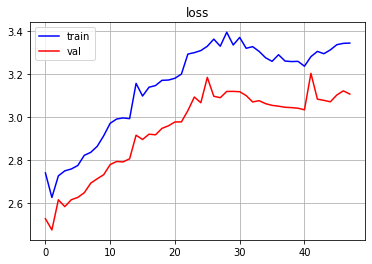

In [65]:
plt.grid(True)
plt.plot(dict_params['train_loss'][2:], label='train', color = 'blue')
plt.plot(dict_params['val_loss'][2:], label='val', color = 'red')
plt.legend()
plt.title('loss')

Text(0.5, 1.0, 'bleu4')

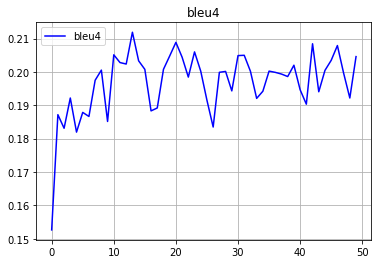

In [66]:
plt.grid(True)
plt.plot(metrics_bleu4, label='bleu4', color = 'blue')
plt.legend()
plt.title('bleu4')

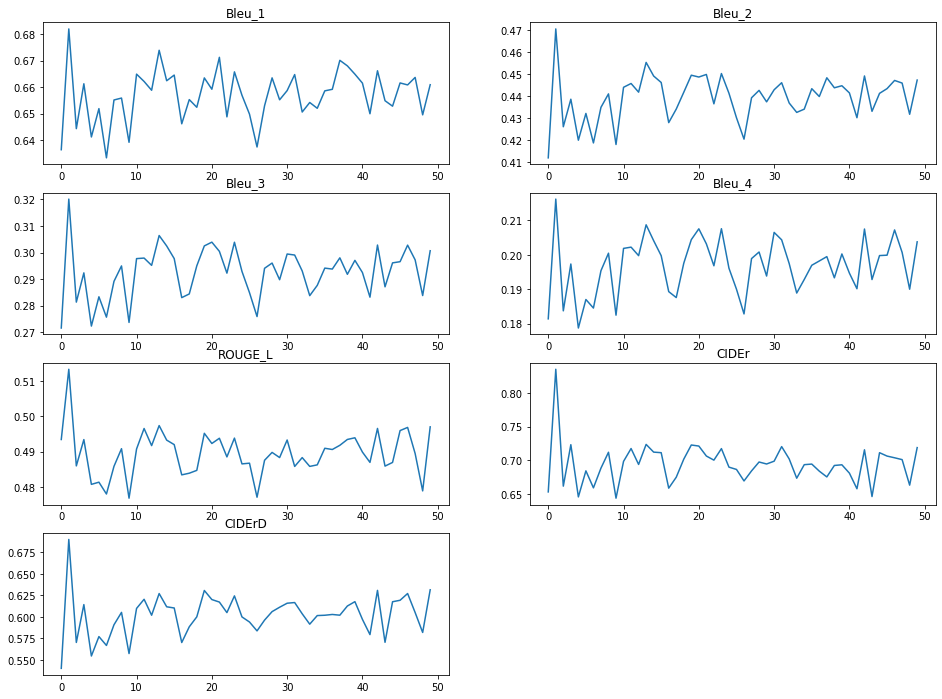

In [67]:
plt.figure(figsize=(16,12))
i = 1
for _, method in scorers:
    if isinstance(method, list):
        for sub_method in method:
            plt.subplot(4,2,i)
            plt.plot(dict_params['val_'+sub_method], label=sub_method)
            plt.title(sub_method)
            i += 1
    else:
        plt.subplot(4,2,i)
        plt.plot(dict_params['val_'+method], label=method)
        plt.title(method)
        i += 1

In [68]:
#torch.save(decoder.state_dict(), 'tmp/model_nlp_0_epoch.pt')

In [84]:
#torch.save(decoder.state_dict(), 'tmp/model_nlp_simple_50_epoch.pt')

In [70]:
batch

{'sentence': tensor([[   1,    4,   52,   82,  454,   37,    4,   62, 1598,    5,    2,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [   1,    4,  508, 1704,   12,    8, 1095, 4169,    9,    4,  519,  153,
            10,    4,  195,  301,   94,    4,  249, 3409],
         [   1,   17, 1085,   11,   17,   84,   20,   41,  136,   73,   28,  240,
           257,    9,  107,  368,    5,    2,    0,    0]]),
 'futures': tensor([[0.4333, 0.3241, 0.3019,  ..., 0.5835, 0.6331, 0.2242],
         [0.9230, 0.0496, 0.2170,  ..., 0.1337, 0.8111, 0.3017],
         [0.8989, 1.6407, 0.5782,  ..., 0.1337, 1.2293, 0.4807]]),
 'labels': tensor([11826, 11827, 11828])}

## Inseption и получение результатов


In [71]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/home/joefox/.pyvenv/diplom-nlp/lib/python3.7/site-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Сгенерируем описание

In [72]:
list(vocab_class.__dict__)

['vocab', 'dict_word_to_index', 'list_words', 'pad_ix', 'unk_ix']

In [73]:
batch

{'sentence': tensor([[   1,    4,   52,   82,  454,   37,    4,   62, 1598,    5,    2,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [   1,    4,  508, 1704,   12,    8, 1095, 4169,    9,    4,  519,  153,
            10,    4,  195,  301,   94,    4,  249, 3409],
         [   1,   17, 1085,   11,   17,   84,   20,   41,  136,   73,   28,  240,
           257,    9,  107,  368,    5,    2,    0,    0]]),
 'futures': tensor([[0.4333, 0.3241, 0.3019,  ..., 0.5835, 0.6331, 0.2242],
         [0.9230, 0.0496, 0.2170,  ..., 0.1337, 0.8111, 0.3017],
         [0.8989, 1.6407, 0.5782,  ..., 0.1337, 1.2293, 0.4807]]),
 'labels': tensor([11826, 11827, 11828])}

In [74]:
batch['futures'][0].unsqueeze(0)

tensor([[0.4333, 0.3241, 0.3019,  ..., 0.5835, 0.6331, 0.2242]])

In [75]:
generate_caption_vectors_neck(decoder, batch['futures'][0].unsqueeze(0), vocab_class)

['<sos>',
 'the',
 'back',
 'view',
 'of',
 'the',
 'person',
 'holding',
 'a',
 'basketball',
 '.',
 '<eos>']

In [76]:
#generate_caption_vectors_neck(decoder, batch['futures'], vocab_class)

In [77]:
def generate_caption(image, decoder, vocab_class, 
                     t, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    caption_prefix = []
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        
        caption_prefix = generate_caption_vectors_neck(decoder, vectors_neck, vocab_class, t, sample, max_len)
        
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [78]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2022-02-02 21:51:17--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Распознаётся pixel.nymag.com (pixel.nymag.com)… 151.101.112.70
Подключение к pixel.nymag.com (pixel.nymag.com)|151.101.112.70|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [переход]
--2022-02-02 21:51:22--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Распознаётся pyxis.nymag.com (pyxis.nymag.com)… 151.101.114.217
Подключение к pyxis.nymag.com (pyxis.nymag.com)|151.101.114.217|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 54731 (53K) [image/jpeg]
Сохранение в: «img.jpg»

img.jpg             100%[===================>]  53,45K  --.-KB/s    за 0,05s   

2022-02-02 21:51:26 (1,14 MB/s) - «img.jpg» сохранён [54731/54731]



/home/joefox/.pyvenv/diplom-nlp/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


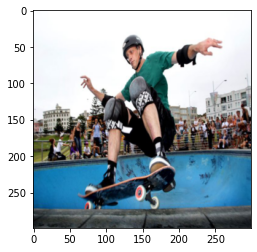

In [79]:
plt.imshow(img)

In [80]:
for i in range(10):
    print(' '.join(generate_caption(img, decoder, vocab_class, t=5., sample=True)[1:-1]))

a man riding a skateboard on top of a ramp .
a man on a skateboard doing a trick on a ramp .
a man on a skateboard doing a trick .
a man is doing a trick on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard in the air .


--2022-02-02 21:51:27--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Распознаётся ccanimalclinic.com (ccanimalclinic.com)… 162.159.135.42
Подключение к ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [переход]
--2022-02-02 21:51:34--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Подключение к ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 106870 (104K) [image/jpeg]
Сохранение в: «img.jpg»

img.jpg             100%[===================>] 104,37K  --.-KB/s    за 0,01s   

2022-02-02 21:51:34 (9,07 MB/s) - «img.jpg» сохранён [106870/106870]



/home/joefox/.pyvenv/diplom-nlp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


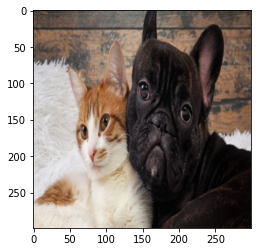

a black and white cat laying on top of a bag .
a black and white cat laying on a bed
a black and white cat laying on a bed .
a black and white cat laying on top of a bed .
a black and white cat laying on top of a bag .
a black and white cat laying on top of a bag .
a black and white cat laying on top of a bag .
a black and white cat laying on a bed .
a black and white cat laying on a bed .
a black and white cat laying on a bed .


In [81]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, decoder, vocab_class, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

In [82]:
# apply your network on images you've found
#
#

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.